# Cifar-10 이미지 분류
### 전체 데이터중 일부만 사용
### Data Augmentation 적용
### 출처: [Achieving 90% accuracy in Object Recognition ](https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/)

#### CIFAR10 데이터 로드

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

(X_train, y_train0), (X_test, y_test0) = cifar10.load_data()
print(X_train.shape, X_train.dtype)
print(y_train0.shape, y_train0.dtype)
print(X_test.shape, X_test.dtype)
print(y_test0.shape, y_test0.dtype)

(50000, 32, 32, 3) uint8
(50000, 1) uint8
(10000, 32, 32, 3) uint8
(10000, 1) uint8


#### 데이터 확인

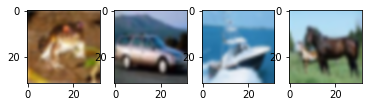

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(141)
plt.imshow(X_train[0], interpolation="bicubic")
plt.grid(False)
plt.subplot(142)
plt.imshow(X_train[4], interpolation="bicubic")
plt.grid(False)
plt.subplot(143)
plt.imshow(X_train[8], interpolation="bicubic")
plt.grid(False)
plt.subplot(144)
plt.imshow(X_train[12], interpolation="bicubic")
plt.grid(False)
plt.show()

#### 자료형 변환 및 스케일링
- X: 실수형으로 정규화
- Y: 1-hot encoding
    * airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [3]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

print(X_train.shape, X_train.dtype)

(50000, 32, 32, 3) float32


In [4]:
Y_train = tf.keras.utils.to_categorical(y_train0, 10)
Y_test = tf.keras.utils.to_categorical(y_test0, 10)
Y_train[:4]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

#### 자료의 일부만 사용하여 모델 테스트 하기

In [5]:
from sklearn.model_selection import train_test_split

seed = 0
X_train, X_test, Y_train, Y_test = train_test_split(X_test, Y_test, 
                                                    test_size=.2, random_state=seed)

#### 모형 구현

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.regularizers import l2
import numpy as np

In [ ]:
np.random.seed(0)
weight_decay = 1e-6

In [7]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay), 
                 input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________

In [12]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(lr=0.001, decay=weight_decay), 
              metrics=['accuracy'])

In [13]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 30:
        lrate = 0.0005
    if epoch > 40:
        lrate = 0.0003
    return lrate

In [14]:
#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)

In [19]:
from tensorflow.keras.callbacks import LearningRateScheduler
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=64),
                    steps_per_epoch=X_train.shape[0] // 64, epochs=50,
                    verbose=2, validation_data=(X_test, Y_test),
                    callbacks=[LearningRateScheduler(lr_schedule)])
#
#history = model.fit(X_train, Y_train, epochs=50, batch_size=64, 
#                    validation_data=(X_test, Y_test), verbose=2)
#

Epoch 1/3
Epoch 1/3
2000/125 - 0s - loss: 0.6890 - acc: 0.7620
125/125 - 6s - loss: 0.5378 - acc: 0.8640 - val_loss: 1.0608 - val_acc: 0.7620
Epoch 2/3
Epoch 1/3
2000/125 - 0s - loss: 0.7105 - acc: 0.7825
125/125 - 6s - loss: 0.5277 - acc: 0.8690 - val_loss: 1.0479 - val_acc: 0.7825
Epoch 3/3
Epoch 1/3
2000/125 - 2s - loss: 0.6784 - acc: 0.7650
125/125 - 16s - loss: 0.5240 - acc: 0.8710 - val_loss: 1.0627 - val_acc: 0.7650


#### 모델 평가하기

In [17]:
scores = model.evaluate(X_test, Y_test, batch_size=128, verbose=2)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100, scores[0]))

2000/2000 - 1s - loss: 0.9975 - acc: 0.7780

Test result: 77.800 loss: 0.997


#### 모델 저장하기

In [18]:
model.save_weights('model/cifar10-partial.h5') 